# KEYBERT(SBERT) 를 이용한 Keyword 추출
- 참고 url : https://wikidocs.net/159467
- SBERT은 sentence_transformers 사용
- transfomers, sentence_transformers 다운로드 필요

In [ ]:
#!pip install transformers
#!pip install sentence_transformers

In [3]:
import pandas as pd
import numpy as np
import itertools
import re

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm

from IPython.display import clear_output

#Okt toknizer 생성
okt = Okt()

# 한국어를 포함하고 있는 다국어 SBERT load
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [8]:
df = pd.read_parquet('after_preprocessing.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361706 entries, 0 to 361705
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   source    361706 non-null  object
 1   content   361706 non-null  object
 2   postdate  361706 non-null  object
 3   platform  361706 non-null  object
dtypes: object(4)
memory usage: 11.0+ MB


# 1. 블로그 글 하나로 Test 해보기

In [6]:
doc = df['content'][0]
tokenized_doc = okt.pos(doc)
stop_word = ['있는','있고','있으니','입니다.','이렇게','있을',]
#print(tokenized_doc)
tokenized_list = [w for w,t in tokenized_doc if  t not in ['Verb'] or w in stop_word]
sentence=' '.join(tokenized_list)


## 1.1 CountVectorizer

- CountVectorizer는 텍스트를 토큰 매트릭스로 변환함
- 4개의 문장안에 10개의 단어로 이루어져 있다면 4x10 매트릭스로 변환됨
- n_gram_range =(2,3) : bigram, trigram 추출
- CountVectiorizer : 단어들의 카운트로 문서를 벡터화
- Candidates : 단어로 잘려진 후보군 생성

In [7]:
# N_gram 단어 추출


#n_gram_range=(2,3)

#count = CountVectorizer(ngram_range=n_gram_range).fit([tok_sentence])
count = CountVectorizer().fit([sentence]) 
candidates = count.get_feature_names()

print('candidates 개수:', len(candidates))
print(candidates[:100])


candidates 개수: 363
['가구', '가능한', '가도', '가득', '가면', '가위', '가장', '각자', '간다', '간단해요', '갈증', '감귤', '같아요', '같은', '거나', '걱정거리', '겨울', '경로', '계서', '계셨고', '계절', '고간', '고백', '곤충', '공간', '공연', '공연장', '공원', '공주', '과실', '과자', '관등', '관람', '굉장히', '구입', '귀엽고', '그냥', '그대', '그러고', '그럼', '그리움', '그린', '글씨', '기간', '기념품', '기분', '기선', '기억', '꼼꼼하게', '꽃길', '꽃다발', '꽃들이', '꽃말', '끼리', '나무', '나중', '낙화', '남아', '남원읍', '내도', '너무', '너무도', '넓어서', '넓은', '노란', '누가', '누구', '느낌', '다른', '다리', '다만', '다양한', '단체', '단체사진', '달달', '달라', '달콤합니다', '대박', '대표', '더욱', '덜하고', '데이트', '도민', '동반', '동백', '동백꽃', '동행', '뒷모습', '따뜻해서', '따로', '딱인', '때문', '라면', '레드', '리가', '리지', '마감', '마다', '마스크', '마시기']


## 1.2 모델 load 및 embedding
- SBERT(sentence Bert)는 기본적으로 BERT의 문장 임베딩의 성능을 우수하게 개선시킨 모델
- 한국어를 포함하고 있는 다국어 SBERT load (참고 : https://www.sbert.net/examples/training/multilingual/README.html#available-pre-trained-models)
- 모델 리스트(https://huggingface.co/models?library=sentence-transformers)
- 한 언어 내에서 또는 여러 언어 사이에서 의미적으로 유사한 문장을 찾기위해 만들어진 모델
- 모델을 이용해 원본 문서와 후보군 단어들을 transformer embedding 진행

In [176]:
# 한국어를 포함하고 있는 다국어 SBERT load
#model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

In [8]:
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

## 1.3 Cosine_similarity
- 임베딩된 원본데이터와 전처리된 데이터를 코사인 유사도를 구함
- 유사도가 높을 수록 원본데이터를 잘 설명한다는 가정
- 유사도 높은 키워드 추출
#### 결과 : 단순히 유사도가 높은 순서로 추출되므로 추출된 키워드도 비슷함, 키워드 추천을 위해 다양한 키워드가 필요함 

In [10]:
top_n = 10

distances = cosine_similarity(doc_embedding, candidate_embeddings)
# argsort = sort전 index값을 반환
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
print(keywords)


['유명하답니다', '사랑스럽답니다', '좋아해서', '아름다웠을', '메리크리스마스', '동백꽃', '꽃들이', '축제', '꽃길', '꽃다발']


## 1.4 Max Sum Similarity

- 데이터 쌍 사이의 최대 합 거리는 데이터 쌍 간의 거리가 최대화되는 데이터 쌍
- 여기서의 의도는 후보 간의 유사성을 최소화하면서 문서와의 후보 유사성을 극대화 하는 것
- doc_embedding : 원본 자료 임베딩
- candidate_embeddings : vectorizing 후 임베딩
- words : 카운트가 높은 단어들 리스트
- top_n : 상위 몇개의 단어를 뽑을 것인지
- nr_candidates : 크기가 커질 수 록 더 다양한 키워드를 만듦
#### 결과 : 다양한 키워드가 뽑히지만 문서내에서 가장 유사한 키워드는 반영이 안됨, 추출할 키워드 갯수가 10개 이상이면 추출 속도 느려짐

In [11]:
def max_sum_sim(doc_embedding, candidate_embeddings, words, top_n, nr_candidates):
    
    # 문서와 각 키워드들 간의 유사도
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    
    # 각 키워드들 간의 유사도
    distances_candidates = cosine_similarity(candidate_embeddings, candidate_embeddings)
    
    
    # 코사인 유사도에 기반하여 키워드들 중 상위 top_n개의 단어를 pick
    words_idx = list(distances.argsort()[0][-nr_candidates:]) 
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]
    
    # 각 키워드들 중에서 가장 덜 유사한 키워드들간의 조합을 계산
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]
    

In [17]:
max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=6, nr_candidates=30)

['인생사진', '데이트', '감귤', '연인들', '자연생활공원', '공주']

## 1.5 Maximal Marginal Relevance
- 텍스트 요약 작업에서 중복을 최소화 하고 결과의 다양성을 극대화 하는 방법 
- 참고 EmbedRank(https://arxiv.org/pdf/1801.04470.pdf)
- 가장 유사한 키워드 선택 -> 다음 문서와 유사하지만 이미 선택된 키워드와는 유사하지 않은 새로운 후보를 반복적으로 선택함
- diversity가 높을수록 유사도가 낮은 키워드 뽑힘
#### 결과 : 가장 유사한 키워드를 포함하며 다양한 키워드를 뽑을 수 있어 키워드 추출로 적합

In [10]:
def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):

    # 문서와 각 키워드들 간의 유사도가 적혀있는 리스트
    word_doc_similarity = cosine_similarity(candidate_embeddings, doc_embedding)

    # 각 키워드들 간의 유사도
    word_similarity = cosine_similarity(candidate_embeddings)

    # 문서와 가장 높은 유사도를 가진 키워드의 인덱스를 추출.
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # keywords_idx = [2]
    keywords_idx = [np.argmax(word_doc_similarity)]

    # 가장 높은 유사도를 가진 키워드의 인덱스를 제외한 문서의 인덱스들
    # 만약, 2번 문서가 가장 유사도가 높았다면
    # ==> candidates_idx = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10 ... 중략 ...]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    # 최고의 키워드는 이미 추출했으므로 top_n-1번만큼 아래를 반복.
    # ex) top_n = 5라면, 아래의 loop는 4번 반복됨.
    for _ in range(top_n - 1):
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # MMR을 계산
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # keywords & candidates를 업데이트
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [14]:
doc_embedding
mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

['꽃다발', '메리크리스마스', '연인들', '축제', '자연생활공원', '비행기', '그리움', '공주', '휴애리', '아름다웠을']

# 2. 한 관광지에 대한 CountVectorizer 키워드 추출


## 2-1 블로그글 리스트를 임베딩 후 키워드 추출
- 한 블로그의 키워드 유사도 순위 보기
- mmr을 이용해 다양한 키워드 뽑기
- mmr 기준 top20 키워드 워드 카운팅
#### 결과 : 여러 블로그를 한번에 임베딩 할 경우 결과값이 좋지 않음

In [63]:
tour = df['source'][0]
total_doc = list(df[df['source']==tour]['content'])

total_tokenized_list=[]

stop_word = ['있는','있고','있으니','입니다.','이렇게','있을',tour, tour.replace(' ',''),'네이버','블로그','제주도']
for d in total_doc:
    total_tokenized_doc = okt.pos(d)
    
    #print(tokenized_doc)
    total_tokenized_list.append(' '.join([w for w,t in total_tokenized_doc if  t not in ['Verb'] and w not in stop_word]))

total_count = CountVectorizer().fit(total_tokenized_list)
total_candidates = total_count.get_feature_names()

total_doc_embedding = model.encode(total_doc)
total_candidate_embeddings = model.encode(total_candidates)

In [59]:
# 한 블로그의 키워드 유사도 순위 보기
top_n = 10

total_distan = cosine_similarity(tfidf_doc_embedding, tfidf_candidate_embeddings)
#dist=np.array([tfidf_distan.flatten()])
# argsort = sort전 index값을 반환
total_keyword = [tfidf_candidates[index] for index in tfidf_distan.argsort()[0][-top_n:]]
#arg = [tfidf_candidates[index] for index in distances.sort()[0][-top_n:]] 
print(total_keyword)

['휴애리핑크뮬리축제', '제주도동백꽃만개시기', '제주귤따기체험', '서귀포감귤체험', '귤따기체험', '제주도귤따기체험', '제주도감귤따기체험', '동백꽃축제', '제주도꽃축제', '서귀포감귤따기체험']


In [76]:
# mmr을 이용해 다양한 키워드 뽑기
total_doc2 = np.array([total_doc_embedding[0]])
mmr(total_doc2, total_candidate_embeddings, total_candidates,20,0.5)

['서귀포감귤따기체험',
 '웨딩촬영',
 '휴애리자연생활공원수국축제가',
 '강아지랑제주도여행',
 '친정엄마',
 '제주겨울동백꽃축제',
 '튤립축제',
 '무료신문',
 'tamron_sp90mm_f2_8_di_macro_vc_usd',
 '질투',
 'hueree_camellia_festival휴애리',
 '생일기념여행',
 '아침미소목장바람도',
 '색달해녀의집',
 '바빴',
 '온라인투어',
 '제주사진찍기좋은곳',
 '기차여행',
 '나의첫생태도감식물편풀',
 '점심가츠정식']

In [81]:
# mmr 기준 top20 키워드 워드 카운팅
total_keyword = []
for i in range(len(total_doc_embedding)):
    temp_doc = np.array([total_doc_embedding[i]])
    key_list = mmr(temp_doc, total_candidate_embeddings, total_candidates,20,0.5)
    total_keyword.extend(key_list)
    

In [83]:
total_count = Counter(total_keyword)
total_count.most_common(20)

[('tamron_sp90mm_f2_8_di_macro_vc_usd', 490),
 ('기차여행', 459),
 ('samsung_galaxy_s10plus', 294),
 ('제주돈아고내점고기집에서', 235),
 ('강원수산남원동', 235),
 ('강아지랑제주도여행', 229),
 ('제주돈아고내점은사랑입니다', 228),
 ('선남선녀', 225),
 ('숙제', 220),
 ('아이와제주여행', 217),
 ('이란', 213),
 ('남원읍휴애리자연생활공원', 201),
 ('안돌오름비밀의숲', 200),
 ('흑돼지동물학대', 189),
 ('무료신문', 182),
 ('고독한미식가', 170),
 ('튤립축제', 164),
 ('질투', 164),
 ('팟캐스트', 161),
 ('일본', 158)]

## 2-2 블로그 별로 임베딩 후 키워드 추출 - 키워드 워드카운팅
- mmr을 이용해 블로그 글 별로 키워드 추출 (블로그 별로 키워드 20개 추출)
- 하나의 관광지에 대해 추출된 모든 키워드를 워드 카운트
- 카운팅이 높은 단어가 해당 관광지 대표 키워드라고 판단
#### 결과: 추출된 키워드가 다른 방법으로 추출한 것 보다 의미가 있음, 해당 방법으로 키워드 추출 진행

In [12]:
# 블로그 글 별로 모델 적용 후 키워드 추출
def keyword(content):
    try:
        result=''
        tokenized_doc = okt.pos(content)
        global stop_word
        #print(tokenized_doc)
        tokenized = ' '.join([w for w,t in tokenized_doc if  t not in ['Verb'] and w not in stop_word])


        count = CountVectorizer().fit([tokenized]) 
        candidates = count.get_feature_names()

        doc_embedding = model.encode([content])
        candidate_embeddings = model.encode(candidates)
        result = ','.join(mmr(doc_embedding, candidate_embeddings, candidates, top_n=20, diversity=0.5))
    
    except Exception as e:
        print(e)
        #print(content)
    return result

In [13]:
# 블로그 별로 키워드 추출 후 parquet 저장
result_df = pd.DataFrame(columns=['source','content','postdate','platform','keyword'])
li = ['휴애리 자연생활공원']
for i,s in enumerate(li):
    print(i+1)
    s_re = re.sub('[^-가-힣0-9]',' ',s)
    stop_word = ['있는','있고','있으니','입니다.','이렇게','있을','제주특별자치도',s,s_re.replace(' ','')]
    stop_word.extend(s_re.split(' '))
    
    keyword_df = df[df['source']==s].copy()
    keyword_df['keyword'] = keyword_df['content'].map(keyword)
    result_df = result_df.append(keyword_df,ignore_index=True)


#result_df.to_parquet("keybert_keyword_new5.parquet",compression='gzip')
result_df

1
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence


,source,content,postdate,platform,keyword
0,휴애리 자연생활공원,언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다...,20211217,naver,"꽃다발,메리크리스마스,연인들,축제,비행기,반려견,그리움,공주,아름다웠을,사진찍기,고..."
1,휴애리 자연생활공원,안녕하세요 아델라 입니다 이번 포스팅 휴애리 자연생활공원 사진 많은 이었어요 저희 ...,20220227,naver,"비싸네,매화축제,동물,날개,추워서,먹이,안녕하세요,냄새,전통,곤충,튤립,지도,장수풍..."
2,휴애리 자연생활공원,제주도 휴애리 자연생활공원 제주 매화축제 구경 제주 서귀포시 남원읍 매일 연중 입장...,20220306,naver,"제주도,자판기,벚꽃,사진찍기,카펫,터널,흑돼지,어린이,겨울,당근,놀이,온실,여행,우..."
3,휴애리 자연생활공원,안녕하세요 량애 절반 지나가고 있네요 아직도 머물러 있어요 제주도 여행 다녀온지 얼...,20220127,naver,"화창해서,감귤따기체험,사진찍기,가족,인터넷,봉투,휴애리,모기,여행,의자,꽃들이,언니..."
4,휴애리 자연생활공원,서귀포 가볼만 휴애리 자연생활공원 동백 포토 진짜 제주도 가서 이렇게 동백 미친듯이...,20220104,naver,"한국,체험,꽃향,남원읍,사진찍기,남녀,백신,행복,마스크,공간,입장권,좋아하는게,커피..."
...,...,...,...,...,...
693,휴애리 자연생활공원,초여름 사실 신록 어울림 느낄 있는 시기 여전히 미세먼지 걱정 앞서긴 공기 맑은 바...,20180529,brunch,"서울대,수확,동물원,즐길거리,장미공원,대중교통,흑돼지,놀이공원,국정원,피자,요리,콘..."
694,휴애리 자연생활공원,여행 비수기 하죠 놓치지 말아야 축제 열린다는 마지막 겨울 만끽 있는 얼음 낚시 벌...,20200122,brunch,"얼음꽃,풍물놀이,딸기,송어축제,겨울,재밌잖아요,국내여행,판매,봄꽃,농장,계절,얼음,..."
695,휴애리 자연생활공원,아이 데리 나들이 하기 좋은 가을 맞아 선선 바람 타고 전국 축제 소식 들리네요 예...,20180913,brunch,"코리아,튤립,저작권,계획,충남,인디언,강은혜,바람,어린이,빅토리아,민둥산,장관,누구..."
696,휴애리 자연생활공원,언제 가도 누구 함께 해도 즐거운 제주 여행 제주도 여행 가시는 들이라면 어느 지역...,20180808,brunch,"즐거운,가족여행,제주신화월드,바베큐,시설,아일랜드,인기,숙박,거리,공원,가격,와이파..."


In [21]:
# 한 관광지에서 추출된 모든 키워드 워드카운팅 
#keyword_df=pd.read_parquet("append_keyword.parquet")
result_key = result_df['keyword']

result_key_list =[]
for k in result_key:
    result_key_list.extend(k.split(','))

from collections import Counter
count = Counter(result_key_list)
#result.most_commonst_common(10)
count.most_common(30)


[('흑돼지', 237),
 ('축제', 217),
 ('제주도', 204),
 ('공간', 196),
 ('겨울', 181),
 ('여행', 156),
 ('매화축제', 156),
 ('네이버', 154),
 ('온실', 141),
 ('체험', 134),
 ('곤충', 126),
 ('제주여행', 117),
 ('감귤', 116),
 ('공원', 108),
 ('휴애리자연생활공원', 106),
 ('사진', 105),
 ('자연', 103),
 ('당근', 100),
 ('계절', 99),
 ('먹이', 94),
 ('여름', 93),
 ('동백꽃', 91),
 ('마스크', 89),
 ('사진찍기', 88),
 ('바람', 85),
 ('남원읍', 83),
 ('계획', 83),
 ('산책', 83),
 ('판매', 81),
 ('동물', 77)]

# 3. TF-IDF Vectorizing으로 전체 글 키워드 추출
- 한 문서 내의 단어의 빈도(TF)와 전체 문서 내의 역 문서 빈도(IDF)를 사용 
- 역 문서 빈도 : 불용어 등과 같이 자주 쓰이는 단어들은 자주 등장하므로 이런것 단어는 중요도를 낮춤 (모든 문서에서 자주 등장하는 단어는 중요도가 낮다고 판단)
#### 결과 : 1차적으로 전처리한 데이터에는 불용어가 별로 없어 오히려 중요한 단어의 중요도가 낮아지므로 해당 전처리 데이터에는 사용하기 힘듦

In [18]:
# 단순 코사인 유사도로 키워드 추출
source = df['source'].unique()
tour_name = source[0]
print(tour_name)
tfidf_df = df[df['source']==tour_name]
#print(tfidf_df)
tfidf_doc = list(tfidf_df['content'])

stop_word = ['있는','있고','있으니','입니다.','이렇게','있을', tour_name, tour_name.replace(' ','')]

tfidf_tok = []
for i,d in enumerate(tfidf_doc):
    tokenized_doc = okt.pos(d)
    tfidf_tok.append(' '.join([w for w,t in tokenized_doc if  t in ['Noun'] or w not in stop_word]))
    #print(len(tfidf_doc),'/',i+1)

tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(tfidf_tok)

tfidf_candidates = tfidf_vectorizer.get_feature_names()

tfidf_doc_embedding = model.encode(tfidf_doc)
tfidf_candidate_embeddings = model.encode(tfidf_candidates)



휴애리 자연생활공원


## 3.1 TF-IDF Cosine_similarity 순위로 키워드 추출
- 각 문서 별 유사도 높은 키워드의 워드카운팅 높은 순서로 추출
#### 결과: 앞서 말한대로 잘 사용하지 않는 키워드가 추출되는것을 볼 수 있다.

In [24]:
# 한 블로그의 키워드 유사도 순위 보기
top_n = 10

tfidf_distan = cosine_similarity(tfidf_doc_embedding, tfidf_candidate_embeddings)
#dist=np.array([tfidf_distan.flatten()])
# argsort = sort전 index값을 반환
tfidf_keyword = [tfidf_candidates[index] for index in tfidf_distan.argsort()[0][-top_n:]]
#arg = [tfidf_candidates[index] for index in distances.sort()[0][-top_n:]] 
print(tfidf_keyword)



['휴애리핑크뮬리축제', '제주도동백꽃만개시기', '제주귤따기체험', '서귀포감귤체험', '귤따기체험', '제주도귤따기체험', '제주도감귤따기체험', '동백꽃축제', '제주도꽃축제', '서귀포감귤따기체험']


In [35]:
result = Counter(top_word.split(' '))
# #result.most_commonst_common(10)
result.most_common(30)

[('제주도동백명소추천', 300),
 ('부산핑크뮬리', 272),
 ('제주동백명소추천', 263),
 ('네이버티켓구매', 254),
 ('제주휴애리후기', 245),
 ('강원수산남원동', 218),
 ('휴애리온라인예매할인', 198),
 ('제주휴애리자연생활공원', 198),
 ('제주휴애리입장권', 179),
 ('제주투어아울렛', 116),
 ('해피댄스파티수국소나무흑돼지야놀자는', 91),
 ('네이버예약', 88),
 ('빼놓지말아야겠습니다', 86),
 ('셀러리제주제주', 82),
 ('고집돌우럭굶주린정도까진', 80),
 ('제주돈아고내점은사랑입니다', 79),
 ('반려견동반입장불가에요', 75),
 ('제주도애견동반맛집', 66),
 ('남원읍휴애리자연생활공원', 66),
 ('부담스러웠겠죠', 65),
 ('꾸며놓았더라고요', 65),
 ('서귀포감귤따기체험', 63),
 ('제주도서귀포가볼만한곳', 61),
 ('제주귤따기체험', 58),
 ('제주서귀포동백꽃', 58),
 ('제주휴애리감귤체험', 58),
 ('제주도귤따기체험', 56),
 ('제주매화예쁜곳', 54),
 ('봄날카페잊지못할거야', 53),
 ('제주도감귤따기체험', 51)]

## 3.2 TF-IDF임베딩 된 문서에 mmr을 적용해 다양한 키워드 뽑기
#### 결과: 키워드의 다양화를 위해 mmr 적용하려 했으나 블로그 하나에 키워드를 추출하는데 시간이 너무 오래걸리고 결과가 좋지않았음

In [53]:
temp_doc = np.array([tfidf_doc_embedding[0]])
mmr(temp_doc,tfidf_candidate_embeddings,tfidf_candidates,10,0.5)

['서귀포감귤따기체험',
 '웨딩촬영',
 '휴애리자연생활공원수국축제가',
 '강아지랑제주도여행',
 '친정엄마',
 '제주겨울동백꽃축제',
 '튤립축제',
 '무료신문',
 'tamron_sp90mm_f2_8_di_macro_vc_usd',
 '질투']

# 4. Top 100 관광지 키워드 정제 (키워드 추출 완료) 
- 2021년 이후의 데이터 크기 순 관광지 + 팀원들 추천 원하는 관광지 100개 추출된 키워드 정제
- 추출된 키워드 중 다른 관광지와 중복하고 의미없는 키워드 제거
- 각 관광지 별 키워드 워드카운팅 후 100개 추출 후 저장

In [15]:
total_df = pd.read_parquet('append_keyword.parquet') 

source = total_df['source'].unique()

In [16]:
key_dict={}
for s in source:
    key_list = []
    remove_set = {'네이버','제주도','블로그','포스트','제주여행','공간','주차장','여행','서울','메뉴',
                  '제주공항','제주도여행','대한민국','한국','제주','제주시','포스팅','판매','검색','공항',
                 '안녕하세요','경남','부산','강릉','강릉시','월요일','청주','청주시','비행기','마스크','제주국제공항',
                 }
    
    for key in total_df[total_df['source']==s]['keyword']:
        key_list.extend(key.split(','))
    
    
    key_list = [k for k in key_list if k not in remove_set]    
    
    count = Counter(key_list)
    
    key_count = count.most_common(100)
    
    key_dict[s]= [w for w,n in key_count[:100]]

In [17]:
def preprocessing(text):
    result = ' '.join(text)
    return result

test_df= pd.DataFrame(data=key_dict.items(),columns=['source','keyword'])

test_df['keyword']= test_df['keyword'].map(preprocessing)

#test_df.to_parquet('top100_keyword.parquet')

In [18]:
test_df

,source,keyword
0,아르떼뮤지엄,미디어아트 미디어 전시관 토끼 경험 입장권 거울 음악 박람회 트릭 색칠 영상 정글 ...
1,산방산,유채꽃 용머리해안 바람 사진 거리 식당 용머리 음식 계획 기도 영업 자연 가격 디저...
2,함덕해수욕장,해수욕장 식당 바람 산책 해변 음식 거리 사진 여름 가족 고기 기도 영업 맛집 흑돼...
3,사계해변,산방산 사진 바람 해변 용머리해안 자연 인스타 식당 거리 시간 계획 송악산 디저트 ...
4,섭지코지,성산읍 성산일출봉 바람 유채꽃 거리 산책 식당 자연 음식 동쪽 사진 성리 드라마 겨...
...,...,...
95,종달리수국길,사진 종달리해안도로 성산일출봉 동쪽 산책 계획 바람 바다 기도 식당 여름 자연 거리...
96,녹산로유채꽃길,벚꽃 유채꽃길 축제 유채꽃 조랑말체험공원 노란 프라자 사진 거리 계획 바람 관광객 ...
97,스누피가든,정원 기념품 만화 캐릭터 찰리 산책 사진 거리 겨울 자연 계획 관광지 여름 체험 야...
98,제주센트럴파크,센트럴파크 한세상 거리 계획 인천 세대 인천광역시 산책 시장 사업 경쟁률 디저트 분...


In [20]:
loc_num=0
print(test_df['source'][loc_num])
test_df['keyword'][loc_num]

아르떼뮤지엄


'미디어아트 미디어 전시관 토끼 경험 입장권 거울 음악 박람회 트릭 색칠 영상 정글 계획 정원 기도 체험 자연 동물 사진 코끼리 녹색 전시 국내 인기 겨울 디지털 거리 디자인 데이트 피아노 기념품 확장 도시 바람 기린 어린이 가족 서양미술 관광 향기 동백꽃 세계 가격 시간 사진찍기 호랑이 관광지 사슴 연출 시공간 전라남도 번개 박물관 기술 공장 인터넷 동영상 전시장 관람객 택시 인스타 색감 온라인 아르떼뮤지엄강릉 전시회 음식 스캔 성인 영업 아동 일요일 강릉아르떼뮤지엄 꽃들이 새로운 꽃밭 청소년 지도 유럽 구매 미술관 평의 아트 광고 산책 감탄 영원한 식당 운영 사자 유채꽃 노래 여수엑스포 남녀 아르떼뮤지엄 여수밤바다 꽃잎 여름 인스타그램 가족여행'

# 5. 계절별 키워드 추출 

In [28]:
keyword_df['postdate']= pd.to_datetime(keyword_df['postdate'],format='%Y/%m/%d')
keyword_df['season'] = keyword_df['postdate'].dt.month
keyword_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 0 to 697
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   source    698 non-null    object        
 1   content   698 non-null    object        
 2   postdate  698 non-null    datetime64[ns]
 3   platform  698 non-null    object        
 4   keyword   698 non-null    object        
 5   season    698 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 38.2+ KB


In [29]:
#df['quarter']=df['postdate'].dt.quarter
def season(month):
    result = 1 
    
    if month in [3, 4, 5]:
        result = 1
    elif month in [6, 7, 8]:
        result = 2
    elif month in [9, 10, 11]:
        result = 3
    else:
        result = 4
        
    return result
    
keyword_df['season']=keyword_df['season'].map(season)

In [32]:
season = list(keyword_df.groupby('season')['keyword'].sum())
len(season)

4

In [158]:
#season[0]

In [187]:
for i,q in enumerate(season):
    result = Counter(q.split(','))
    print(i,result.most_common(20))
    print()

0 [(' 자연생활공원', 63), (' 휴애리자연생활공원', 45), (' 휴애리', 33), (' 매화축제', 27), (' 공간', 23), (' 곤충', 21), (' 벚꽃', 20), (' 축제', 20), (' 제주특별자치도', 18), (' 겨울', 16), (' 계획', 16), (' 사진찍기', 14), (' 흑돼지', 12), (' 판매', 12), (' 인터넷', 11), (' 꽃들이', 11), (' 제주도여행', 11), (' 가족여행', 11), (' 여행', 10), (' 인스타그램', 9)]

1 [(' 자연생활공원', 78), (' 휴애리자연생활공원', 41), (' 휴애리', 37), (' 곤충', 26), (' 제주특별자치도', 24), (' 축제', 21), (' 매화축제', 20), (' 흑돼지', 16), (' 공간', 16), (' 여행', 15), (' 인터넷', 14), (' 유럽', 14), (' 여름', 14), (' 판매', 12), (' 꽃들이', 10), (' 겨울', 10), (' 제주여행', 10), (' 계획', 10), (' 사진찍기', 9), (' 토끼', 9)]

2 [(' 자연생활공원', 51), (' 휴애리', 37), (' 휴애리자연생활공원', 35), (' 곤충', 35), (' 제주특별자치도', 20), (' 흑돼지', 14), (' 공간', 14), (' 겨울', 14), (' 축제', 13), (' 판매', 13), (' 매화축제', 12), (' 감귤', 12), (' 계획', 10), (' 인터넷', 9), (' 산책', 8), (' 당근', 7), (' 관광', 7), (' 제주여행', 7), (' 하늘정원', 7), (' 토끼', 7)]

3 [(' 자연생활공원', 95), (' 휴애리', 68), (' 휴애리자연생활공원', 60), (' 겨울', 39), (' 제주특별자치도', 35), (' 매화축제', 32), (' 축제', 31), (' 곤충', 27), (' 흑돼지', 

In [35]:
season_size = keyword_df.groupby('season').size()
season_size

season
1    161
2    154
3    136
4    247
dtype: int64

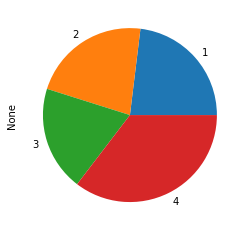

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax = season_size.plot(kind='pie')
plt.show()

# 5. 계절별 데이터 TF-IDF를 이용해 벡터라이징

In [37]:
#df = pd.read_parquet('after_preprocessing.parquet')
df['postdate']= pd.to_datetime(df['postdate'],format='%Y/%m/%d')
df['season'] = df['postdate'].dt.month
df.info()

source = df['source'].unique()
df

# doc_list = df[df['source']==source[0]]['content']
# doc_list

,source,content,postdate,platform,season
0,휴애리 자연생활공원,언니 평소 가보고 싶어 하던 휴애리 축제 다녀왔어요 지금 한참 만발 해서 꽃길 걷다...,2021-12-17,naver,4
1,휴애리 자연생활공원,안녕하세요 아델라 입니다 이번 포스팅 휴애리 자연생활공원 사진 많은 이었어요 저희 ...,2022-02-27,naver,4
2,휴애리 자연생활공원,제주도 휴애리 자연생활공원 제주 매화축제 구경 제주 서귀포시 남원읍 매일 연중 입장...,2022-03-06,naver,1
3,휴애리 자연생활공원,안녕하세요 량애 절반 지나가고 있네요 아직도 머물러 있어요 제주도 여행 다녀온지 얼...,2022-01-27,naver,4
4,휴애리 자연생활공원,서귀포 가볼만 휴애리 자연생활공원 동백 포토 진짜 제주도 가서 이렇게 동백 미친듯이...,2022-01-04,naver,4
...,...,...,...,...,...
361701,1100고지(휴게소),크레마 알맞게 덮힌 진한 커피 두툼 내리고 감싸 온기 먼저 마시는 살짝 서리 펑펑 ...,2020-12-20,brunch,4
361702,(주)제주해양레저 투명카약,제주해양레저 즐기며 특별한 경험 되는 제주 오션 파크 제주 해양레저 즐기러 오는 사...,2019-06-18,naver,2
361703,(주)제주해양레저 투명카약,제주 가볼만 제주도 렌트카 지도 보고 버스 타고 뚜벅 여행 권역별 지선 버스 노선 ...,2021-05-08,naver,1
361704,(주)제주해양레저 투명카약,우리나라 바다 모두 특색 있고 아름다워 사계절 내내 예쁜 비경 자랑 하는데요 제주도...,2018-12-24,naver,4


In [8]:
source = list(df['source'].unique())
tour = source[0]
tour_df = df[df['source']==tour]

season_list = list(tour_df[tour_df['season']==1]['content'])
#season_list

# vectorizer = TfidfVectorizer(analyzer = 'char',min_df=2)

# vectorizer.fit(tok_list)
# #sorted(vectorizer.vocabulary_.items())
# sorted(vectorizer.vocabulary_.items())

NameError: name 'source' is not defined

In [9]:
tok_list=[]
for i,d in enumerate(season_list):
    tokenized_doc = okt.pos(d)
    stop_word = ['있는','있고','있으니','입니다.','이렇게','있을', tour, tour.replace(' ','')]
    tok_list.append(' '.join([w for w,t in tokenized_doc if  t not in ['Verb'] or w not in stop_word]))
    #print(len(season_list),'/',i)


NameError: name 'season_list' is not defined

In [158]:
candidates = vectorizer.get_feature_names()



doc_embedding = model.encode(season_list)
candidate_embeddings = model.encode(candidates)


# distances = cosine_similarity(doc_embedding, candidate_embeddings)
# # argsort = sort전 index값을 반환
# keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]] 
# keywords

#mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.5)

In [154]:
len(doc_embedding)

161

In [ ]:
!pip list